1. Mount Drive and set paths



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Main project folder
PROJECT_DIR  = "/content/drive/MyDrive/Training dataset/NEW Training dataset - Copy"
RAW_DIR      = os.path.join(PROJECT_DIR, "rawdata")
DERIV_DIR    = os.path.join(PROJECT_DIR, "derivatives")
PREPROC_DIR  = os.path.join(PROJECT_DIR, "preprocessed")
IMG_DIR      = os.path.join(PREPROC_DIR, "imagesTr")
LBL_DIR      = os.path.join(PREPROC_DIR, "labelsTr")
MESH_DIR     = os.path.join(PROJECT_DIR, "meshes")

for d in [PREPROC_DIR, IMG_DIR, LBL_DIR, MESH_DIR]:
    os.makedirs(d, exist_ok=True)

print("PROJECT_DIR =", PROJECT_DIR)
print("RAW_DIR     =", RAW_DIR)
print("DERIV_DIR   =", DERIV_DIR)
print("PREPROC_DIR =", PREPROC_DIR)


Mounted at /content/drive
PROJECT_DIR = /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy
RAW_DIR     = /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/rawdata
DERIV_DIR   = /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/derivatives
PREPROC_DIR = /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/preprocessed


2. Find CT and label files and inspect one

In [2]:
import glob
import nibabel as nib
import numpy as np

# CT: /rawdata/sub-*/ *_ct.nii.gz
ct_paths = sorted(glob.glob(os.path.join(RAW_DIR, "sub-*", "*_ct.nii.gz")))
# Labels: /derivatives/sub-*/ *_seg-vert_msk.nii.gz
label_paths_raw = sorted(glob.glob(os.path.join(DERIV_DIR, "sub-*", "*_seg-vert_msk.nii.gz")))

print("Number of CTs:", len(ct_paths))
print("Number of raw labels:", len(label_paths_raw))
print("Example CT:", ct_paths[0] if ct_paths else "NONE")
print("Example label:", label_paths_raw[0] if label_paths_raw else "NONE")

# Inspect first CT/label pair
ct = nib.load(ct_paths[0])
lbl = nib.load(label_paths_raw[0])
print("CT shape:", ct.shape)
print("CT voxel spacing:", ct.header.get_zooms())
print("Label shape:", lbl.shape)

lbl_data = lbl.get_fdata()
print("Unique labels (first 20):", np.unique(lbl_data).astype(int)[:20])


Number of CTs: 50
Number of raw labels: 50
Example CT: /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/rawdata/sub-gl003/sub-gl003_dir-ax_ct.nii.gz
Example label: /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/derivatives/sub-gl003/sub-gl003_dir-ax_seg-vert_msk.nii.gz
CT shape: (512, 512, 214)
CT voxel spacing: (np.float32(0.291016), np.float32(0.291016), np.float32(1.25))
Label shape: (512, 512, 214)
Unique labels (first 20): [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


3. Resampling and preprocessing to imagesTr / labelsTr

In [3]:
!pip install SimpleITK -q
import SimpleITK as sitk

def resample_image(img_itk, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = img_itk.GetSpacing()
    original_size    = img_itk.GetSize()
    out_size = [
        int(round(original_size[i] * (original_spacing[i] / out_spacing[i])))
        for i in range(3)
    ]
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(out_spacing)
    resampler.SetSize(out_size)
    resampler.SetOutputDirection(img_itk.GetDirection())
    resampler.SetOutputOrigin(img_itk.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkNearestNeighbor if is_label else sitk.sitkBSpline)
    return resampler.Execute(img_itk)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.8 MB/s eta 0:00:00


In [4]:
from tqdm import tqdm

for ct_path in tqdm(ct_paths, total=len(ct_paths)):
    sub_dir = os.path.basename(os.path.dirname(ct_path))         # e.g. sub-gl003_dir-ax
    seg_glob = glob.glob(os.path.join(DERIV_DIR, sub_dir, "*_seg-vert_msk.nii.gz"))
    if not seg_glob:
        continue
    seg_path = seg_glob[0]

    case_id = sub_dir
    print("Processing", case_id)

    ct_itk  = sitk.ReadImage(ct_path)
    seg_itk = sitk.ReadImage(seg_path)

    # 1 mm isotropic
    ct_res  = resample_image(ct_itk, out_spacing=(1.0, 1.0, 1.0), is_label=False)
    seg_res = resample_image(seg_itk, out_spacing=(1.0, 1.0, 1.0), is_label=True)

    # clip HU and z-score normalize
    ct_arr = sitk.GetArrayFromImage(ct_res).astype(np.float32)
    ct_arr = np.clip(ct_arr, -1000, 2000)
    mean = ct_arr.mean()
    std  = ct_arr.std() + 1e-8
    ct_arr = (ct_arr - mean) / std

    ct_res_norm = sitk.GetImageFromArray(ct_arr)
    ct_res_norm.CopyInformation(ct_res)

    out_img_path = os.path.join(IMG_DIR, f"{case_id}_0000.nii.gz")
    out_lbl_path = os.path.join(LBL_DIR, f"{case_id}.nii.gz")

    sitk.WriteImage(ct_res_norm, out_img_path)
    sitk.WriteImage(seg_res,      out_lbl_path)


  0%|          | 0/50 [00:00<?, ?it/s]

Processing sub-gl003


  2%|▏         | 1/50 [00:20<16:24, 20.10s/it]

Processing sub-gl016


  4%|▍         | 2/50 [00:35<13:43, 17.15s/it]

Processing sub-gl047


  6%|▌         | 3/50 [00:50<12:55, 16.51s/it]

Processing sub-gl090


  8%|▊         | 4/50 [01:04<11:48, 15.41s/it]

Processing sub-gl124


 10%|█         | 5/50 [01:20<11:35, 15.46s/it]

Processing sub-gl240


 12%|█▏        | 6/50 [01:34<11:09, 15.22s/it]

Processing sub-gl247


 14%|█▍        | 7/50 [01:53<11:40, 16.29s/it]

Processing sub-gl295


 16%|█▌        | 8/50 [02:11<11:52, 16.96s/it]

Processing sub-gl364


 18%|█▊        | 9/50 [02:25<10:54, 15.97s/it]

Processing sub-gl453


 20%|██        | 10/50 [02:43<10:58, 16.45s/it]

Processing sub-verse500


 22%|██▏       | 11/50 [04:06<23:57, 36.85s/it]

Processing sub-verse503


 24%|██▍       | 12/50 [05:35<33:31, 52.92s/it]

Processing sub-verse504


 26%|██▌       | 13/50 [06:58<38:06, 61.81s/it]

Processing sub-verse506


 28%|██▊       | 14/50 [09:22<52:06, 86.85s/it]

Processing sub-verse507


 30%|███       | 15/50 [10:38<48:41, 83.48s/it]

Processing sub-verse510


 32%|███▏      | 16/50 [12:39<53:41, 94.76s/it]

Processing sub-verse514


 34%|███▍      | 17/50 [14:20<53:03, 96.48s/it]

Processing sub-verse518


 36%|███▌      | 18/50 [16:27<56:27, 105.85s/it]

Processing sub-verse519


 38%|███▊      | 19/50 [18:47<1:00:00, 116.14s/it]

Processing sub-verse521


 40%|████      | 20/50 [20:04<52:09, 104.33s/it]  

Processing sub-verse525


 42%|████▏     | 21/50 [20:47<41:27, 85.77s/it] 

Processing sub-verse527


 44%|████▍     | 22/50 [22:27<42:04, 90.16s/it]

Processing sub-verse532


 46%|████▌     | 23/50 [24:59<48:52, 108.62s/it]

Processing sub-verse533


 48%|████▊     | 24/50 [27:09<49:53, 115.13s/it]

Processing sub-verse534


 50%|█████     | 25/50 [28:39<44:51, 107.68s/it]

Processing sub-verse535


 52%|█████▏    | 26/50 [30:20<42:16, 105.69s/it]

Processing sub-verse536


 54%|█████▍    | 27/50 [31:58<39:34, 103.23s/it]

Processing sub-verse537


 56%|█████▌    | 28/50 [33:25<36:07, 98.51s/it] 

Processing sub-verse539


 58%|█████▊    | 29/50 [35:40<38:18, 109.46s/it]

Processing sub-verse541


 60%|██████    | 30/50 [37:04<33:52, 101.62s/it]

Processing sub-verse542


 62%|██████▏   | 31/50 [39:27<36:10, 114.23s/it]

Processing sub-verse544


 64%|██████▍   | 32/50 [40:26<29:15, 97.54s/it] 

Processing sub-verse557


 66%|██████▌   | 33/50 [42:14<28:31, 100.68s/it]

Processing sub-verse561


 68%|██████▊   | 34/50 [43:03<22:44, 85.25s/it] 

Processing sub-verse564


 70%|███████   | 35/50 [44:26<21:05, 84.38s/it]

Processing sub-verse565


 72%|███████▏  | 36/50 [46:14<21:22, 91.59s/it]

Processing sub-verse577


 74%|███████▍  | 37/50 [48:41<23:28, 108.32s/it]

Processing sub-verse581


 76%|███████▌  | 38/50 [51:00<23:29, 117.42s/it]

Processing sub-verse584


 78%|███████▊  | 39/50 [52:51<21:10, 115.48s/it]

Processing sub-verse586


 80%|████████  | 40/50 [55:22<21:01, 126.12s/it]

Processing sub-verse588


 82%|████████▏ | 41/50 [56:46<17:00, 113.41s/it]

Processing sub-verse593


 84%|████████▍ | 42/50 [58:32<14:51, 111.44s/it]

Processing sub-verse594


 86%|████████▌ | 43/50 [59:55<11:59, 102.81s/it]

Processing sub-verse596


 88%|████████▊ | 44/50 [1:00:47<08:45, 87.51s/it]

Processing sub-verse605


 90%|█████████ | 45/50 [1:01:45<06:33, 78.62s/it]

Processing sub-verse619


 92%|█████████▏| 46/50 [1:03:28<05:44, 86.13s/it]

Processing sub-verse629


 94%|█████████▍| 47/50 [1:04:41<04:06, 82.03s/it]

Processing sub-verse631


 96%|█████████▌| 48/50 [1:06:13<02:50, 85.03s/it]

Processing sub-verse641


 98%|█████████▊| 49/50 [1:07:06<01:15, 75.39s/it]

Processing sub-verse642


100%|██████████| 50/50 [1:08:02<00:00, 81.66s/it]


In [6]:
# Quick check of preprocessed files
pp_imgs = sorted(glob.glob(os.path.join(IMG_DIR, "*.nii.gz")))
pp_lbls = sorted(glob.glob(os.path.join(LBL_DIR, "*.nii.gz")))
print("Preprocessed images:", len(pp_imgs))
print("Preprocessed labels:", len(pp_lbls))
print("Example preprocessed image:", pp_imgs[0] if pp_imgs else "NONE")
print("Example preprocessed label:", pp_lbls[0] if pp_lbls else "NONE")


Preprocessed images: 98
Preprocessed labels: 98
Example preprocessed image: /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/preprocessed/imagesTr/sub-gl003_0000.nii.gz
Example preprocessed label: /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/preprocessed/labelsTr/sub-gl003.nii.gz


Visualize CT + labels (one case)

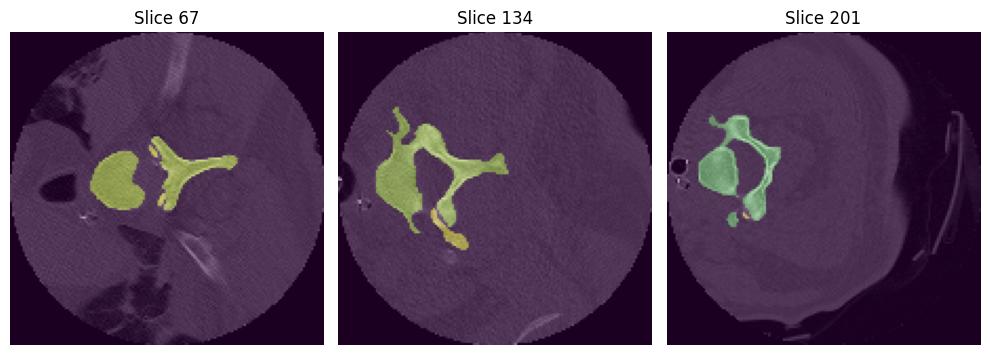

In [29]:
import matplotlib.pyplot as plt

case_id = os.path.basename(ct_paths[0]).replace("_ct.nii.gz","")  # one example
img = nib.load(os.path.join(IMG_DIR, case_id+"_0000.nii.gz")).get_fdata()
lbl = nib.load(os.path.join(LBL_DIR, case_id+".nii.gz")).get_fdata()

z1, z2, z3 = img.shape[2]//4, img.shape[2]//2, 3*img.shape[2]//4

fig, axs = plt.subplots(1,3,figsize=(10,4))
for ax, z in zip(axs,[z1,z2,z3]):
    ax.imshow(img[:,:,z], cmap='gray')
    ax.imshow(lbl[:,:,z], alpha=0.4)
    ax.set_title(f"Slice {z}")
    ax.axis('off')
plt.tight_layout()
plt.show()


4. Train/val/test split and presence check

In [7]:
import json
from sklearn.model_selection import train_test_split

all_imgs = sorted(glob.glob(os.path.join(IMG_DIR, "*.nii.gz")))
case_ids = [os.path.basename(p).replace("_0000.nii.gz", "") for p in all_imgs]
print("Total cases:", len(case_ids))

train_ids, temp_ids = train_test_split(case_ids, test_size=0.2, random_state=42)
val_ids, test_ids   = train_test_split(temp_ids, test_size=0.5, random_state=42)

splits = {
    "train": train_ids,
    "val":   val_ids,
    "test":  test_ids
}

SPLIT_FILE = os.path.join(PREPROC_DIR, "splits_80_10_10.json")
with open(SPLIT_FILE, "w") as f:
    json.dump(splits, f, indent=2)

print("Saved splits to:", SPLIT_FILE)
print("Train/Val/Test sizes:", len(train_ids), len(val_ids), len(test_ids))


Total cases: 98
Saved splits to: /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/preprocessed/splits_80_10_10.json
Train/Val/Test sizes: 78 10 10


In [8]:
def check_ids(ids):
    for cid in ids:
        img = os.path.join(IMG_DIR, cid + "_0000.nii.gz")
        lbl = os.path.join(LBL_DIR, cid + ".nii.gz")
        if not (os.path.exists(img) and os.path.exists(lbl)):
            print("Missing:", cid)
            return
    print("All files present for", len(ids), "cases")

check_ids(splits["train"])
check_ids(splits["val"])
check_ids(splits["test"])


All files present for 78 cases
All files present for 10 cases
All files present for 10 cases


5. 3D U‑Net dataset, model, and loss

In [9]:
!pip install torch torchvision torchio -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 19.5 MB/s eta 0:00:00


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchio as tio

# reload splits for safety
with open(SPLIT_FILE) as f:
    splits = json.load(f)

PATCH_SIZE = (128, 128, 128)

class VerseDataset(Dataset):
    def __init__(self, ids, augment=False):
        self.ids = ids
        self.augment = augment

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        cid = self.ids[idx]
        img_path = os.path.join(IMG_DIR, cid + "_0000.nii.gz")
        lbl_path = os.path.join(LBL_DIR, cid + ".nii.gz")

        img_nii = nib.load(img_path)
        lbl_nii = nib.load(lbl_path)
        img = img_nii.get_fdata().astype(np.float32)
        lbl = lbl_nii.get_fdata().astype(np.int16)

        # random 3D crop
        D, H, W = img.shape
        pd, ph, pw = PATCH_SIZE
        sd = np.random.randint(0, max(1, D - pd + 1))
        sh = np.random.randint(0, max(1, H - ph + 1))
        sw = np.random.randint(0, max(1, W - pw + 1))

        img_patch = img[sd:sd+pd, sh:sh+ph, sw:sw+pw]
        lbl_patch = lbl[sd:sd+pd, sh:sh+ph, sw:sw+pw]

        img_patch = np.expand_dims(img_patch, 0)   # (1,D,H,W)
        return torch.from_numpy(img_patch), torch.from_numpy(lbl_patch).long()


In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet3D(nn.Module):
    def __init__(self, in_ch=1, n_classes=30):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, 16)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool3d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up3 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec3 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec2 = DoubleConv(64, 32)
        self.up1 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec1 = DoubleConv(32, 16)

        self.out_conv = nn.Conv3d(16, n_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        b  = self.bottleneck(self.pool3(e3))

        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)


In [12]:
# compute max label to set N_CLASSES
lbl_paths = glob.glob(os.path.join(LBL_DIR, "*.nii.gz"))
mx = 0
for p in lbl_paths:
    d = nib.load(p).get_fdata()
    mx = max(mx, int(d.max()))
print("Max label value =", mx)

N_CLASSES = mx + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_ch=1, n_classes=N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

import torch.nn.functional as F

def dice_ce_loss(logits, targets, num_classes):
    ce = F.cross_entropy(logits, targets)

    probs = F.softmax(logits, dim=1)
    targets_onehot = F.one_hot(targets, num_classes=num_classes)
    targets_onehot = targets_onehot.permute(0, 4, 1, 2, 3).float()

    dims = (0, 2, 3, 4)
    numer = 2 * (probs * targets_onehot).sum(dims)
    denom = (probs + targets_onehot).sum(dims) + 1e-8
    dice_per_class = numer / denom
    dice = dice_per_class[1:].mean()

    return ce + (1 - dice)

criterion = lambda logits, lbls: dice_ce_loss(logits, lbls, N_CLASSES)


Max label value = 28


In [13]:
BATCH_SIZE = 1

train_ds = VerseDataset(splits["train"], augment=True)
val_ds   = VerseDataset(splits["val"],   augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1,         shuffle=False, num_workers=0)

img, lbl = train_ds[0]
print("Sample patch shapes:", img.shape, lbl.shape, "labels:", lbl.min().item(), "to", lbl.max().item())


Sample patch shapes: torch.Size([1, 128, 128, 128]) torch.Size([128, 128, 128]) labels: 0 to 21


Visualization

A. Show sagittal / coronal / axial slices with masks

CT shape: (512, 1869, 125)


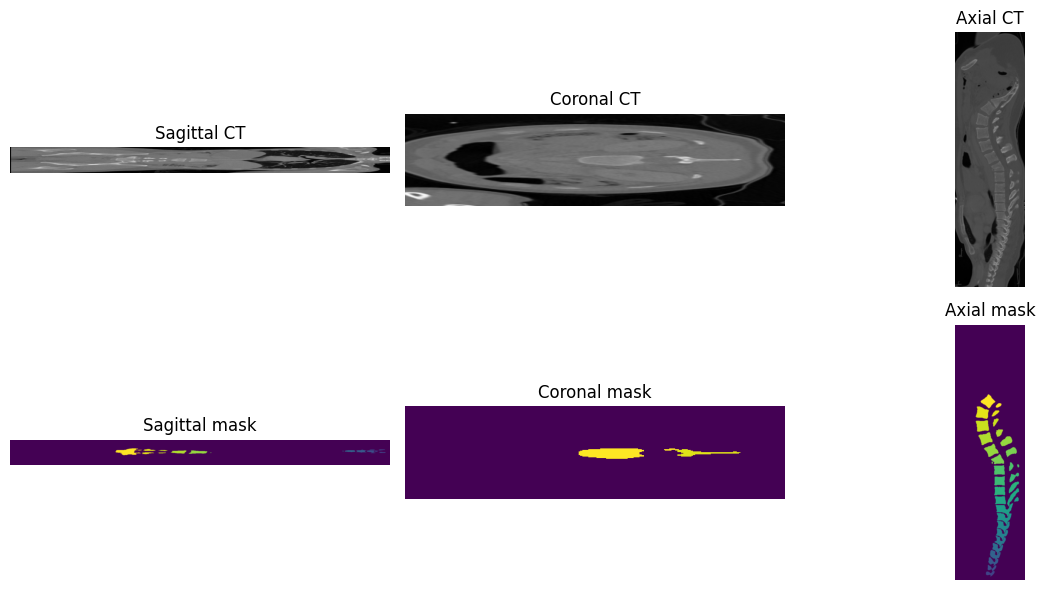

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ct_vol and mask_vol already loaded with nibabel
print("CT shape:", ct_vol.shape)   # (X, Y, Z)

# Choose middle slices for now
x_sag = ct_vol.shape[0] // 2
y_cor = ct_vol.shape[1] // 2
z_ax  = ct_vol.shape[2] // 2

sag_ct  = ct_vol[x_sag, :, :]
cor_ct  = ct_vol[:, y_cor, :]
ax_ct   = ct_vol[:, :, z_ax]

sag_msk = mask_vol[x_sag, :, :]
cor_msk = mask_vol[:, y_cor, :]
ax_msk  = mask_vol[:, :, z_ax]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes[0,0].imshow(sag_ct.T, cmap="gray");   axes[0,0].set_title("Sagittal CT")
axes[0,1].imshow(cor_ct.T, cmap="gray");   axes[0,1].set_title("Coronal CT")
axes[0,2].imshow(ax_ct.T,  cmap="gray");   axes[0,2].set_title("Axial CT")

axes[1,0].imshow(sag_msk.T); axes[1,0].set_title("Sagittal mask")
axes[1,1].imshow(cor_msk.T); axes[1,1].set_title("Coronal mask")
axes[1,2].imshow(ax_msk.T);  axes[1,2].set_title("Axial mask")

for a in axes.ravel(): a.axis("off")
plt.tight_layout(); plt.show()


 Normalize CT slices to 0–255 uint8

In [20]:
import numpy as np
import imageio.v3 as imageio

def to_uint8(img):
    img = img.astype(np.float32)
    img = img - img.min()
    if img.max() > 0:
        img = img / img.max()
    img = (img * 255).astype(np.uint8)
    return img

ct_sag_png = to_uint8(sag_ct.T)
ct_cor_png = to_uint8(cor_ct.T)
ct_ax_png  = to_uint8(ax_ct.T)

imageio.imwrite("ct_sagittal.png", ct_sag_png)
imageio.imwrite("ct_coronal.png",  ct_cor_png)
imageio.imwrite("ct_axial.png",    ct_ax_png)


Save masks as integer PNGs

In [21]:
mask_sag_png = sag_msk.T.astype(np.uint16)
mask_cor_png = cor_msk.T.astype(np.uint16)
mask_ax_png  = ax_msk.T.astype(np.uint16)

imageio.imwrite("mask_sagittal.png", mask_sag_png)
imageio.imwrite("mask_coronal.png",  mask_cor_png)
imageio.imwrite("mask_axial.png",    mask_ax_png)



B.Load PNGs and build 3D planes

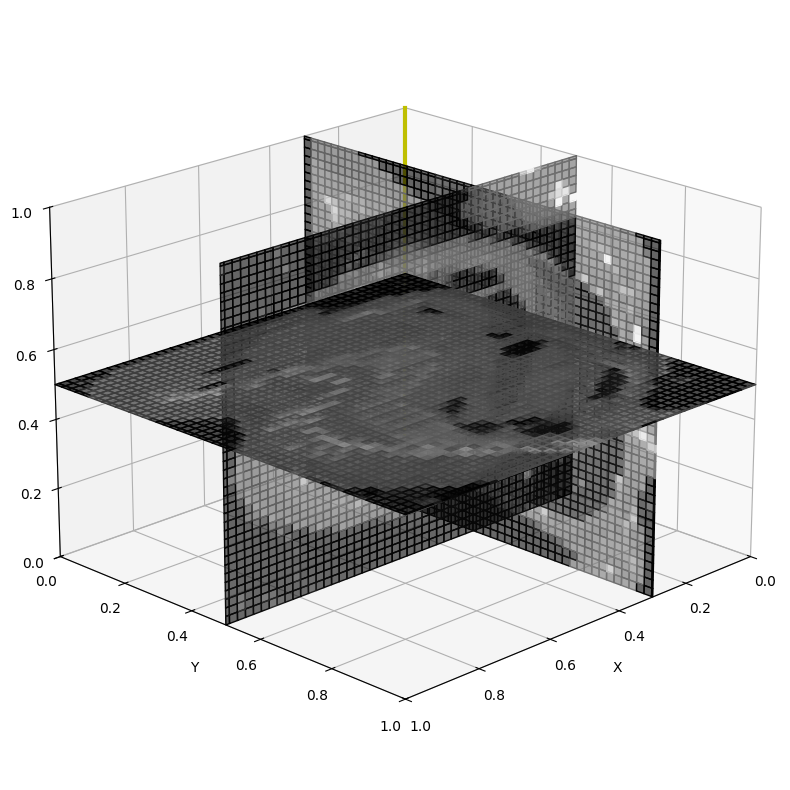

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio.v3 as imageio

# Load the 2D views you just created
ct_sagittal = imageio.imread("ct_sagittal.png")   # sagittal
ct_coronal  = imageio.imread("ct_coronal.png")    # coronal
ct_axial    = imageio.imread("ct_axial.png")      # axial

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Simple spine centerline just for context
z_line = np.linspace(0, 1, 20)
ax.plot(np.zeros_like(z_line), np.zeros_like(z_line), z_line, "y-", lw=3)

# Normalize coordinates so planes roughly align in a cube [0,1]
# SAGITTAL: YZ plane at x = 0.3
nz, ny = ct_sagittal.shape[:2]
y_sag = np.linspace(0, 1, ny)
z_sag = np.linspace(0, 1, nz)
Y_sag, Z_sag = np.meshgrid(y_sag, z_sag)
ax.plot_surface(
    0.3 * np.ones_like(Y_sag),
    Y_sag,
    Z_sag,
    facecolors=plt.cm.gray(ct_sagittal / 255.0),
    alpha=0.6,
    shade=False,
)

# CORONAL: XZ plane at y = 0.5
nz, nx = ct_coronal.shape[:2]
x_cor = np.linspace(0, 1, nx)
z_cor = np.linspace(0, 1, nz)
X_cor, Z_cor = np.meshgrid(x_cor, z_cor)
ax.plot_surface(
    X_cor,
    0.5 * np.ones_like(X_cor),
    Z_cor,
    facecolors=plt.cm.gray(ct_coronal / 255.0),
    alpha=0.6,
    shade=False,
)

# AXIAL: XY plane at z = 0.5
ny, nx = ct_axial.shape[:2]
x_ax = np.linspace(0, 1, nx)
y_ax = np.linspace(0, 1, ny)
X_ax, Y_ax = np.meshgrid(x_ax, y_ax)
ax.plot_surface(
    X_ax,
    Y_ax,
    0.5 * np.ones_like(X_ax),
    facecolors=plt.cm.gray(ct_axial / 255.0),
    alpha=0.7,
    shade=False,
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()


Load vertebra centroids from the JSON

In [23]:
import json
import pandas as pd

with open(json_path) as f:
    annotations = json.load(f)

# For VerSe'20 the list usually contains one direction entry + vertebra entries
vertebra_entries = [e for e in annotations if "X" in e and "Y" in e and "Z" in e]

df = pd.DataFrame(vertebra_entries)  # columns: X, Y, Z, label, etc.
print(df.head())


   label      X       Y     Z
0      5  237.2  1810.4  57.8
1      6  245.9  1771.2  58.1
2      7  255.8  1726.9  58.3
3      8  271.2  1677.4  57.9
4      9  287.5  1625.7  58.4


C.Plot vertebra points on your sagittal snapshot

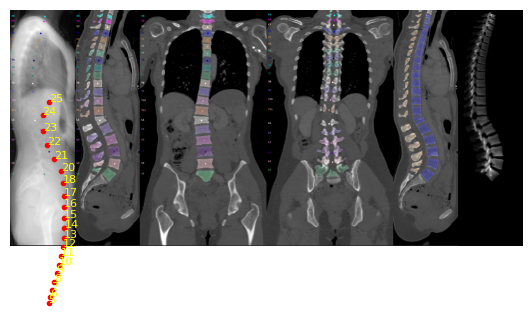

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

png_path  = base + "derivatives/sub-verse642/sub-verse642_dir-sag_seg-vert_snp.png"
img = Image.open(png_path)
plt.figure(figsize=(8, 4))
plt.imshow(img)

for _, row in df.iterrows():
    x, y, lab = row["X"], row["Y"], int(row["label"])
    plt.plot(x, y, "ro", markersize=3)
    plt.text(x, y, str(lab), color="yellow", fontsize=8)

plt.axis("off")
plt.show()


D.project vertebrae into your 3D planes

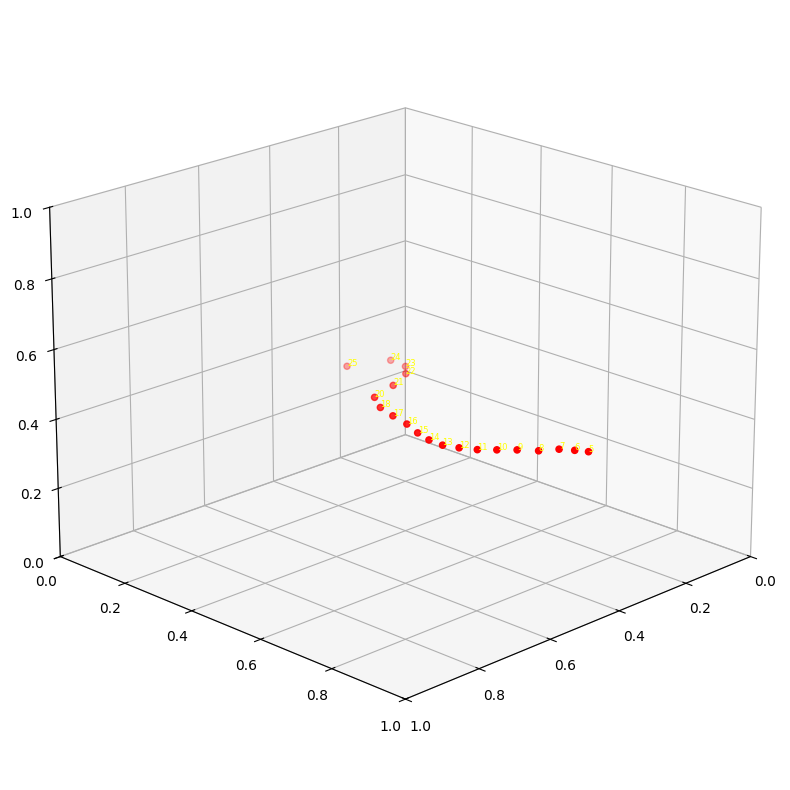

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio.v3 as imageio

# 1) Create figure + axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 2) Load PNGs
ct_sagittal = imageio.imread("ct_sagittal.png")
ct_coronal  = imageio.imread("ct_coronal.png")
ct_axial    = imageio.imread("ct_axial.png")

# 3) Plot planes (same as before)
# ... your plot_surface code here ...

# 4) Plot vertebra points AFTER planes, BEFORE plt.show()
xs = df["X"].values / ct_vol.shape[0]
ys = df["Y"].values / ct_vol.shape[1]
zs = df["Z"].values / ct_vol.shape[2]

ax.scatter(xs, ys, zs, c="red", s=20)
for x, y, z, lab in zip(xs, ys, zs, df["label"].values):
    ax.text(x, y, z, str(int(lab)), color="yellow", fontsize=6)

# 5) Final settings + show
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()


E.Extract and inspect one vertebra in 3D

In [27]:
import numpy as np

def extract_patch(volume, center, size=64):
    x, y, z = map(int, center)
    r = size // 2
    x0, x1 = max(x-r, 0), min(x+r, volume.shape[0])
    y0, y1 = max(y-r, 0), min(y+r, volume.shape[1])
    z0, z1 = max(z-r, 0), min(z+r, volume.shape[2])
    return volume[x0:x1, y0:y1, z0:z1]

target_label = 18  # choose any label present in df
row = df[df["label"] == target_label].iloc[0]
center = (row["X"], row["Y"], row["Z"])

patch_ct   = extract_patch(ct_vol,   center, size=64)
patch_mask = extract_patch(mask_vol, center, size=64)
print("Patch shape:", patch_ct.shape)


Patch shape: (64, 64, 64)


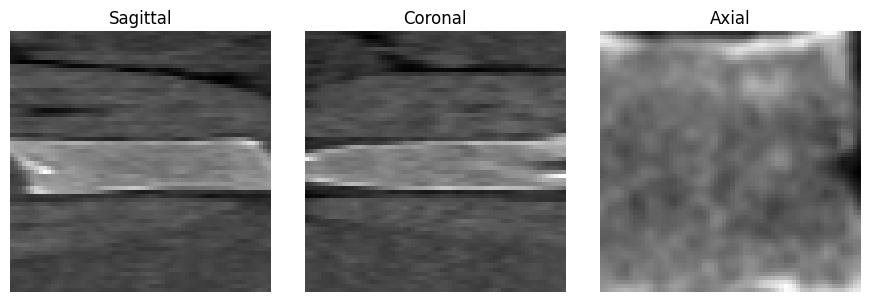

In [28]:
import matplotlib.pyplot as plt

cx, cy, cz = np.array(patch_ct.shape) // 2

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(patch_ct[cx, :, :].T, cmap="gray"); axes[0].set_title("Sagittal")
axes[1].imshow(patch_ct[:, cy, :].T, cmap="gray"); axes[1].set_title("Coronal")
axes[2].imshow(patch_ct[:, :, cz].T, cmap="gray"); axes[2].set_title("Axial")
for a in axes: a.axis("off")
plt.tight_layout(); plt.show()


6. Mesh generation and calibration experiment

In [14]:
!pip install scikit-image -q
from skimage import measure

def vox2world(verts, affine):
    v_h = np.c_[verts, np.ones(len(verts))]
    return (affine @ v_h.T).T[:, :3]

# example: build meshes for one case (extend to loop over all if needed)
case_id = os.path.basename(ct_paths[0]).replace("_ct.nii.gz","")
lbl_path = os.path.join(LBL_DIR, case_id + ".nii.gz")
lbl_nii = nib.load(lbl_path)
lbl = lbl_nii.get_fdata().astype(np.int16)
affine = lbl_nii.affine

unique_labels = [l for l in np.unique(lbl) if l != 0]

for lab in unique_labels:
    mask = (lbl == lab).astype(np.uint8)
    if mask.sum() == 0:
        continue
    verts, faces, _, _ = measure.marching_cubes(mask, level=0.5, spacing=(1,1,1))
    verts_world = vox2world(verts, affine)

    out_path = os.path.join(MESH_DIR, f"{case_id}_lab{lab}.obj")
    with open(out_path, "w") as f:
        f.write("# vertebra mesh\n")
        for v in verts_world:
            f.write(f"v {v[0]:.3f} {v[1]:.3f} {v[2]:.3f}\n")
        for tri in faces + 1:
            f.write(f"f {tri[0]} {tri[1]} {tri[2]}\n")
    print("Saved", out_path)


Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab1.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab2.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab3.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab4.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab5.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab6.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab7.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab8.obj
Saved /content/drive/MyDrive/Training dataset/NEW Training dataset - Copy/meshes/sub-gl003_dir-ax_lab9.obj
Saved /content/drive/MyDrive/Training

In [15]:
# calibration experiment
import numpy as np

def load_obj_vertices(path):
    verts = []
    with open(path,"r") as f:
        for line in f:
            if line.startswith("v "):
                x,y,z = map(float,line.split()[1:])
                verts.append([x,y,z])
    return np.array(verts, dtype=np.float32)

# choose one mesh
obj_files = sorted(glob.glob(os.path.join(MESH_DIR, f"{case_id}_lab*.obj")))
print("OBJ files:", [os.path.basename(f) for f in obj_files])
obj_path = obj_files[0]
verts = load_obj_vertices(obj_path)

K = 10
idx = np.random.choice(len(verts), size=K, replace=False)
P_ct = verts[idx]

def random_transform(max_rot_deg=3.0, max_trans_mm=4.0):
    ang = np.deg2rad(np.random.uniform(-max_rot_deg, max_rot_deg, size=3))
    tx,ty,tz = np.random.uniform(-max_trans_mm, max_trans_mm, size=3)
    Rx = np.array([[1,0,0],
                   [0,np.cos(ang[0]),-np.sin(ang[0])],
                   [0,np.sin(ang[0]), np.cos(ang[0])]])
    Ry = np.array([[ np.cos(ang[1]),0,np.sin(ang[1])],
                   [0,1,0],
                   [-np.sin(ang[1]),0,np.cos(ang[1])]])
    Rz = np.array([[np.cos(ang[2]),-np.sin(ang[2]),0],
                   [np.sin(ang[2]), np.cos(ang[2]),0],
                   [0,0,1]])
    R = Rz @ Ry @ Rx
    t = np.array([tx,ty,tz])
    return R,t

def point_reg(P,Q):
    Pm, Qm = P.mean(0), Q.mean(0)
    H = (P-Pm).T @ (Q-Qm)
    U,S,Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R)<0:
        Vt[-1,:]*=-1
        R = Vt.T @ U.T
    t = Qm - R @ Pm
    return R,t

def rot_err_deg(R_est,R_true):
    Rdelta = R_est @ R_true.T
    tr = np.trace(Rdelta)
    a = np.arccos(np.clip((tr-1)/2,-1,1))
    return np.rad2deg(a)

def run_experiment(K, noise_std, num_trials=100):
    idx = np.random.choice(len(verts), size=K, replace=False)
    P_ct = verts[idx]
    trans, rot = [], []

    for _ in range(num_trials):
        R_true,t_true = random_transform()
        P_ar_true = (R_true @ P_ct.T).T + t_true
        P_ar_meas = P_ar_true + np.random.normal(0,noise_std,P_ar_true.shape)
        R_est,t_est = point_reg(P_ct,P_ar_meas)
        trans.append(np.linalg.norm(t_est - t_true))
        rot.append(rot_err_deg(R_est,R_true))

    return np.mean(trans), np.std(trans), np.mean(rot), np.std(rot)

Ks     = [10,20,30]
noises = [0.5,1.0,1.5]
results = []

for K in Ks:
    for ns in noises:
        mt,st,mr,sr = run_experiment(K,ns)
        results.append((K,ns,mt,st,mr,sr))

print("K\tnoise\tmean_trans±sd (mm)\tmean_rot±sd (deg)")
for K,ns,mt,st,mr,sr in results:
    print(f"{K}\t{ns:.1f}\t{mt:.2f}±{st:.2f}\t\t{mr:.2f}±{sr:.2f}")


OBJ files: ['sub-gl003_dir-ax_lab1.obj', 'sub-gl003_dir-ax_lab10.obj', 'sub-gl003_dir-ax_lab11.obj', 'sub-gl003_dir-ax_lab12.obj', 'sub-gl003_dir-ax_lab2.obj', 'sub-gl003_dir-ax_lab3.obj', 'sub-gl003_dir-ax_lab4.obj', 'sub-gl003_dir-ax_lab5.obj', 'sub-gl003_dir-ax_lab6.obj', 'sub-gl003_dir-ax_lab7.obj', 'sub-gl003_dir-ax_lab8.obj', 'sub-gl003_dir-ax_lab9.obj']
K	noise	mean_trans±sd (mm)	mean_rot±sd (deg)
10	0.5	3.37±1.72		0.94±0.40
10	1.0	6.41±3.57		1.62±0.78
10	1.5	11.04±5.99		2.78±1.39
20	0.5	2.07±1.33		0.55±0.29
20	1.0	4.99±2.77		1.26±0.60
20	1.5	7.40±4.41		1.90±0.97
30	0.5	1.79±1.16		0.47±0.25
30	1.0	3.51±1.77		0.94±0.41
30	1.5	5.28±3.05		1.33±0.63


Error vs. noise / landmarks plots

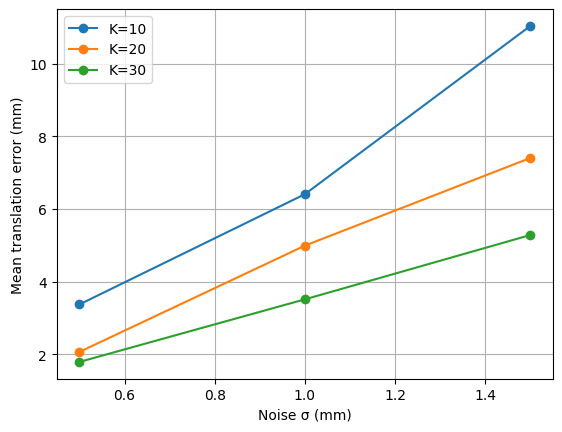

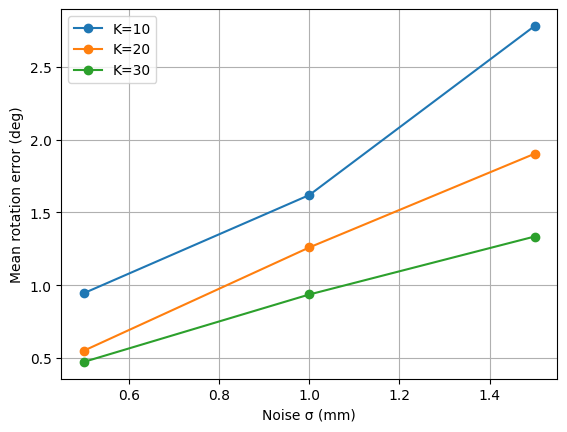

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# suppose 'results' from previous cell: list of (K, ns, mt, st, mr, sr)
Ks = sorted(list(set(r[0] for r in results)))
noises = sorted(list(set(r[1] for r in results)))

# plot: translation error vs noise for each K
plt.figure()
for K in Ks:
    xs = []; ys = []
    for ns in noises:
        for r in results:
            if r[0]==K and r[1]==ns:
                xs.append(ns); ys.append(r[2])  # mean trans error
    plt.plot(xs, ys, marker='o', label=f'K={K}')
plt.xlabel('Noise σ (mm)')
plt.ylabel('Mean translation error (mm)')
plt.legend()
plt.grid(True)
plt.show()

# similar for rotation error
plt.figure()
for K in Ks:
    xs = []; ys = []
    for ns in noises:
        for r in results:
            if r[0]==K and r[1]==ns:
                xs.append(ns); ys.append(r[4])  # mean rot error
    plt.plot(xs, ys, marker='o', label=f'K={K}')
plt.xlabel('Noise σ (mm)')
plt.ylabel('Mean rotation error (deg)')
plt.legend()
plt.grid(True)
plt.show()


8. Gradio vertebra viewer

In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import gradio as gr

# choose one case with JSON and PNG from original derivatives
base = PROJECT_DIR + "/"
ct_path   = base + "rawdata/sub-verse642/sub-verse642_dir-sag_ct.nii.gz"
mask_path = base + "derivatives/sub-verse642/sub-verse642_dir-sag_seg-vert_msk.nii.gz"
json_path = base + "derivatives/sub-verse642/sub-verse642_dir-sag_seg-subreg_ctd.json"

ct_vol   = nib.load(ct_path).get_fdata()
mask_vol = nib.load(mask_path).get_fdata()

with open(json_path) as f:
    annotations = json.load(f)
vertebra_entries = [e for e in annotations if "X" in e and "Y" in e and "Z" in e]
df = pd.DataFrame(vertebra_entries)


In [17]:
def overlay_slice(ct_slice, mask_slice, alpha=0.4):
    img = ct_slice.astype(np.float32)
    img -= img.min()
    if img.max() > 0:
        img /= img.max()
    img = (img * 255).astype(np.uint8)
    img_rgb = np.stack([img, img, img], axis=-1)

    mask_bin = (mask_slice > 0).astype(np.uint8)
    color = np.zeros_like(img_rgb)
    color[..., 0] = 255

    overlay = img_rgb.copy()
    overlay[mask_bin == 1] = (
        (1 - alpha) * img_rgb[mask_bin == 1] + alpha * color[mask_bin == 1]
    ).astype(np.uint8)

    return Image.fromarray(overlay)

def show_vertebra(label:int):
    if label not in df["label"].values:
        return None, None, None

    row = df[df["label"] == label].iloc[0]
    x, y, z = int(row["X"]), int(row["Y"]), int(row["Z"])

    sag_ct = ct_vol[x, :, :]
    cor_ct = ct_vol[:, y, :]
    ax_ct  = ct_vol[:, :, z]

    sag_msk = mask_vol[x, :, :]
    cor_msk = mask_vol[:, y, :]
    ax_msk  = mask_vol[:, :, z]

    sag_img = overlay_slice(sag_ct.T, sag_msk.T)
    cor_img = overlay_slice(cor_ct.T, cor_msk.T)
    ax_img  = overlay_slice(ax_ct.T,  ax_msk.T)

    return sag_img, cor_img, ax_img

available_labels = sorted(df["label"].unique().astype(int).tolist())

demo = gr.Interface(
    fn=show_vertebra,
    inputs=gr.Slider(
        minimum=min(available_labels),
        maximum=max(available_labels),
        step=1,
        value=min(available_labels),
        label="Vertebra label"
    ),
    outputs=[
        gr.Image(label="Sagittal view"),
        gr.Image(label="Coronal view"),
        gr.Image(label="Axial view"),
    ],
    title="VerSe Vertebra Explorer",
    description="Select a vertebra label to see sagittal, coronal, and axial CT slices with the segmentation mask overlaid."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1367029a52123d923c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [31]:
demo = gr.Interface(
    fn=show_vertebra,
    inputs=gr.Slider(
        minimum=min(available_labels),
        maximum=max(available_labels),
        step=1,
        value=min(available_labels),
        label="Vertebra label"
    ),
    outputs=[
        gr.Image(label="Sagittal view"),
        gr.Image(label="Coronal view"),
        gr.Image(label="Axial view"),
    ],
    title="VerSe Vertebra Explorer",
    description="Select a vertebra label to see slices with segmentation overlaid."
)


In [32]:
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3de61e37617adfe2f9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
